# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

for data in [geo_data_0, geo_data_1, geo_data_2]:
    print(data.info())
    print(data.describe(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries

Целевой признак - product

Признаки необходимо будет масштабировать.

Если предположить что столбец id состоит из уникальных значений, то его смысл для модели теряется. Если применить на него порядковое кодирование получим значение индексов, а если OHE - кучу столбцов с флажками индексов. Да и для задачи он как таковой не имеет ценности, нужно определить регион, а не конкретное месторождение.

In [3]:
for data in [geo_data_0, geo_data_1, geo_data_2]:
    print(data['id'].unique().shape, data.duplicated().sum())

(99990,) 0
(99996,) 0
(99996,) 0


Несущественно. Уберем его на время обучения модели.

In [4]:
def target_separator(df, target):
    targ = df[target]
    feat = df.drop([target, 'id'], axis=1)
    return targ, feat

In [5]:
target_0, features_0 = target_separator(geo_data_0, 'product')
print(target_0.shape, features_0.shape)

target_1, features_1 = target_separator(geo_data_1, 'product')
print(target_1.shape, features_1.shape)

target_2, features_2 = target_separator(geo_data_2, 'product')
print(target_2.shape, features_2.shape)

(100000,) (100000, 3)
(100000,) (100000, 3)
(100000,) (100000, 3)


# 2. Обучение и проверка модели

In [6]:
def model_cycle(feat, targ):
    
    feat_train, feat_val, targ_train, targ_val = train_test_split(
        feat, targ, test_size=0.25, random_state=42)
    
    scaler = StandardScaler()
    scaler.fit(feat_train)
    feat_train = scaler.transform(feat_train)
    feat_val = scaler.transform(feat_val)
    
    model = LinearRegression()
    model.fit(feat_train, targ_train)
    pred_val = model.predict(feat_val)
    
    mean_prod = pred_val.mean()
    rmse = (mean_squared_error(targ_val, pred_val)) ** 0.5
    print('Cредний запас сырья:', mean_prod) 
    print('RMSE:', rmse)
    
    return targ_val, pred_val

In [7]:
print('Для geo_data_0:')
target_val_0, predicted_0 = model_cycle(features_0, target_0)
print(target_val_0.shape, predicted_0.shape, '\n')
target_val_0 = pd.Series(target_val_0)
predicted_0 = pd.Series(predicted_0)


print('Для geo_data_1:')
target_val_1, predicted_1 = model_cycle(features_1, target_1)
print(target_val_1.shape, predicted_1.shape, '\n')
target_val_1 = pd.Series(target_val_1)
predicted_1 = pd.Series(predicted_1)

print('Для geo_data_2:')
target_val_2, predicted_2 = model_cycle(features_2, target_2)
print(target_val_2.shape, predicted_2.shape)
target_val_2 = pd.Series(target_val_2)
predicted_2 = pd.Series(predicted_2)

Для geo_data_0:
Cредний запас сырья: 92.39879990657768
RMSE: 37.75660035026169
(25000,) (25000,) 

Для geo_data_1:
Cредний запас сырья: 68.71287803913762
RMSE: 0.8902801001028834
(25000,) (25000,) 

Для geo_data_2:
Cредний запас сырья: 94.77102387765939
RMSE: 40.145872311342174
(25000,) (25000,)


Чем меньше RMSE, тем лучше. Отклонения в geo_data_1 до идиального минимальны. Можно ли это считать переобучением?

In [8]:
for target in [target_val_0, target_val_1, target_val_2]:
    mean = pd.Series(target.mean(), index=target.index)
    rmse = (mean_squared_error(target, mean)) ** 0.5
    print('Среднее на целевом:', target.mean()) 
    print('RMSE:', rmse)

Среднее на целевом: 92.32595637084387
RMSE: 44.27662690128472
Среднее на целевом: 68.72538074722745
RMSE: 45.9446674190625
Среднее на целевом: 95.15099907171961
RMSE: 44.78232422904734


Судя по значениям которые дают случайные модели, geo_data_2 почти рандомна, но опять же, если RMSE придает больший вес именно большим значениям ошибок, то пара значений колоссально отличающихся от оригинального и дает эти 40. Тоже самое может быть и про geo_data_0.

Хотя среднее реальных значений и предсказанных почти неразличаются. Это может подтверждать предположение что есть несколько значений с отличием как в одну так и в другую сторону.

Мне сложно делать выводы из этих оценок. geo_data_1 - переобучение, geo_data_2 - недообучение, geo_data_0 - плохая модель?

# 3. Подготовка к расчёту прибыли

Попробуем такое рассуждение: Нужно понять какой обьем надо добыть чтобы затраченный бюджет окупился, но не просто окупился, а еще и принес прибыль. Потратить 10 миллиардов чтобы заработать эти же 10 миллиардов, не хорошо, конечно, но и не ужасно.

Исходя из этого предположения для определения минимального среднего объёма сырья в месторождениях региона, достаточного для его разработки, нужно всего лишь:

In [9]:
min_mean = 10000000000 / 4500000
min_mean

2222.222222222222

Это означает, что 200 скважин (10млрд/50млн), на которые хватает бюджета, должны принести не менее 2222 тысячей баррелей, чтобы только вернуть вложения. Все что ниже данного значения принесет убытки компании.

In [10]:
print(target_0.sort_values(ascending=False)[:200].sum(), predicted_0.sort_values(ascending=False)[:200].sum())
print(target_1.sort_values(ascending=False)[:200].sum(), predicted_1.sort_values(ascending=False)[:200].sum())
print(target_2.sort_values(ascending=False)[:200].sum(), predicted_2.sort_values(ascending=False)[:200].sum())

36966.747929072015 30881.46328814699
27589.081548181137 27748.751366664626
37910.29539635329 29728.84780825545


Ради интереса просто посмотреть возможный уровень добычи по данным. Зато заметно откуда взялись оценки RMSE. Модели по геоданным 0 и 2 настроены довольно пессимистично, а по данным 1 даже чуточку больше. Это касательно лучших месторождений не учитывая общего индекса, просто так посмотреть, что прибыль похоже будет в среднем в 10-11 раз выше затрат.

Функция для расчета прибыли:

In [11]:
def profit(trgt, prdct, count):
    pred_sort = prdct.sort_values(ascending=False)[:count]
    select = trgt[pred_sort.index][:count]
    return select.sum() * 4500000 - 10000000000

Берем лучшие из предсказанных значений, ищем индексы этих значений в "фактических" данных и по ним считаем прибыль, которая будет по факту добычи. По идее возвращается валовая прибыль.

# 4. Расчёт прибыли и рисков 

За раз разведать можем 500 месторождений, из них надо выбрать 200 самых даровитых и посчитать с них прибыль. И так 1000 раз, для 3 регионов.

Как я понимаю задачу, нужно оценить именно риск, который несет в себе предсказание моделью, сравнивая результаты, которые дают точки с одинаковым индексом в predicted и target. Таким образом можно будет увидеть чего стоят ошибки модели.

В values собираем распределение прибыли 1000 выборок с 200 месторождений. Функция должна возвращаять среднюю прибыль, 95% доверительный интервал и риски, процент которых найдем в заисимости от кол-ва возможных результатов с отрицательной прибылью из значений values.

In [12]:
state = np.random.RandomState(42)

def bootstrap_1000(targ, pred, n, count):
    
    values = []
    
    for i in range(1000):
        targ_sample = targ.sample(n=n, replace=True, random_state=state)
        pred_sample = pred[targ_sample.index]
        values.append(profit(targ_sample, pred_sample, count))
        
    values = pd.Series(values)
    
    mean = values.mean()
    lower_int = values.quantile(0.05)
    upper_int = values.quantile(0.95)
    loss = pd.Series(list(map(lambda x: x < 0, values)))
    
    print("Средняя прибыль:", mean)
    print("95%-ый доверительный интервал:", lower_int, upper_int)
    print("Риски понести убытки в %:", loss.sum() / len(loss))
    
    return values

Для geo_data_0:
Средняя прибыль: 73434977985.68651
95%-ый доверительный интервал: 68669599956.35058 78059589323.35788
Риски понести убытки в %: 0.0


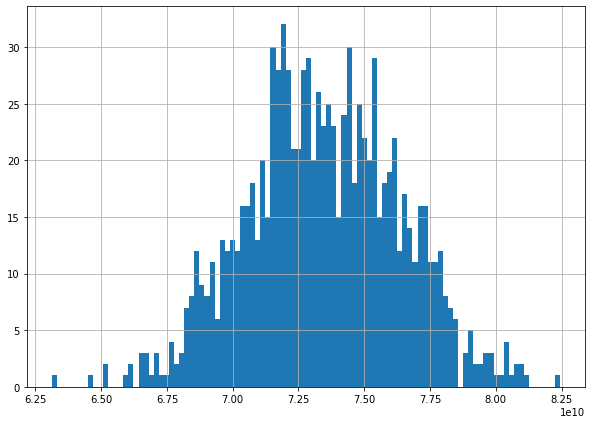

In [16]:
print('Для geo_data_0:')
profit_val_0 = bootstrap_1000(target_0, predicted_0, 500, 200)
profit_val_0.hist(bins=100, figsize=(10, 7))

Для geo_data_1:
Средняя прибыль: 51668397153.27755
95%-ый доверительный интервал: 46859262175.723404 56499427716.09702
Риски понести убытки в %: 0.0


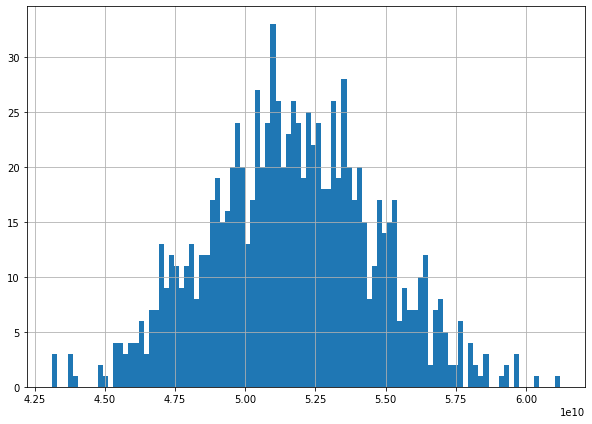

In [17]:
print('Для geo_data_1:')
profit_val_1 = bootstrap_1000(target_1, predicted_1, 500, 200)
profit_val_1.hist(bins=100, figsize=(10, 7))

Для geo_data_2:
Средняя прибыль: 75471240204.06502
95%-ый доверительный интервал: 70755997220.61606 80244177762.93996
Риски понести убытки в %: 0.0


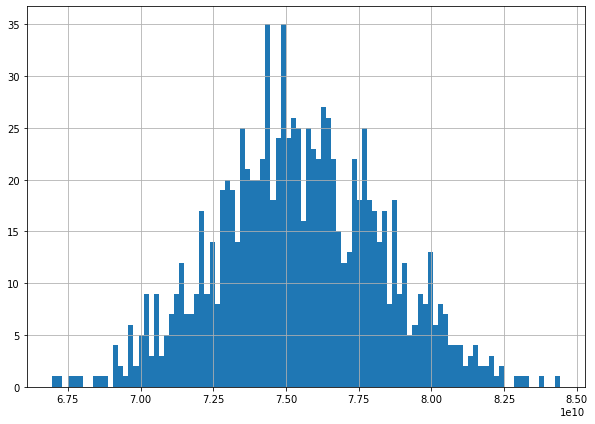

In [18]:
print('Для geo_data_2:')
profit_val_2 = bootstrap_1000(target_2, predicted_2, 500, 200)
profit_val_2.hist(bins=100, figsize=(10, 7))

Что за чудесный бизнес! Прибыль в 7,5 раза больше чем вложил и никаких рисков!

Как видно из значений средней прибыли и гистограмм, самым прибыльным регионом является geo_data_2, его и стоит разрабатывать.

Но что если посмотреть на результаты без модели, как ее предсказания сказались на прибыли?

In [19]:
print('Для geo_data_0 без модели:')
bootstrap_1000(target_0, target_0, 500, 200)
print()
print('Для geo_data_1 без модели:')
bootstrap_1000(target_1, target_1, 500, 200)
print()
print('Для geo_data_2 без модели:')
bootstrap_1000(target_2, target_2, 500, 200)
print()

Для geo_data_0 без модели:
Средняя прибыль: 113999927810.41098
95%-ый доверительный интервал: 110845281242.71716 117197084954.25568
Риски понести убытки в %: 0.0

Для geo_data_1 без модели:
Средняя прибыль: 94648087512.7829
95%-ый доверительный интервал: 91215176091.52586 97865737751.4754
Риски понести убытки в %: 0.0

Для geo_data_2 без модели:
Средняя прибыль: 116462789681.631
95%-ый доверительный интервал: 113149487402.8492 119578928742.10936
Риски понести убытки в %: 0.0



Ожидаемая прибыль не была завышена моделью в сравнении с оценкой прибыли по "фактическим" данным. Также нет изменений относительно лучшего региона для добычи. Так что несмотря на пессимизм модели, результат оказался схожим.

---

Тут идея была в том что модель не уловила тенденцию по самим точкам. Индексы 200 лучших в target и prediction различаются. Модель не нашла самые даровитые точки, котороые по факту есть в регионе. Она занизила оценки одних, завысила оценки других и RMSE нам этого не покажет.

Если мы будем опираться на предсказания модели для того чтобы определить в каких именно точках ставить скважины, мы недоберем в среднем 41млрд прибыли. Вот в чем была идея опираться на фактические данные, посмотреть на то что будет по факту добычи из месторождений. А если смотреть на данные полученные с помощью модели, то это с точки зрения реальности, что нам неизвестен target.

По мимо оценки кол-ва сырья в месторождениях, можно попробовать еще и классифицировать эти месторождения, чтобы подсказать модели регрессии, где потенциально должно быть больше, чтобы повысить точность оценки запасов сырья в самых даровитых месторождениях. Мне кажется в такой задаче важна точность, потому что выкачать надо по-максимому.

In [21]:
#Все же надо проверить какой регион оказался лучшим по данным модели
#Cудя по 5 итерации в 3 пункте, это будет не geo_data_2, а geo_data_0

print('Для geo_data_0:')
bootstrap_1000(predicted_0, predicted_0, 500, 200)
print()
print('Для geo_data_1:')
bootstrap_1000(predicted_1, predicted_1, 500, 200)
print()
print('Для geo_data_2:')
bootstrap_1000(predicted_2, predicted_2, 500, 200)
print()

Для geo_data_0:
Средняя прибыль: 93638795708.36485
95%-ый доверительный интервал: 91660401680.54213 95707547670.42331
Риски понести убытки в %: 0.0

Для geo_data_1:
Средняя прибыль: 95010432427.89418
95%-ый доверительный интервал: 91584699028.78217 98541737339.17108
Риски понести убытки в %: 0.0

Для geo_data_2:
Средняя прибыль: 92969946109.0619
95%-ый доверительный интервал: 91301026807.35173 94670729523.40628
Риски понести убытки в %: 0.0



Согласно данным модели самым прибыльным регионом был бы geo_data_1 реально являющийся самым не прибыльным. Зато оценка прибыли с региона максимально точна в сравнении с результатами без модели, хоть и немного оптимистична.

Судя по всему это все как раз связанно со столь низкой оценкой RMSE. Они и выстроились как раз также как и по RMSE 1-0-2.

В сравнении с этим все что выше просто не имело смысла...